In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from subgrid_parameterization.preprocess import SAM_helpers as sam
from subgrid_parameterization.preprocess.C14 import get_C14
from subgrid_parameterization.preprocess.mixing_length import get_mixing_length

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from sklearn.metrics import r2_score

In [3]:
path0 = "/glade/work/stepheba/les_and_clubb_benchmark_runs/stepheba_sam_runs/derecho/"

# path = 'sam-bomex/'
# file = 'BOMEX_64x64x75_100m_40m_1s'
# file = 'BOMEX_3d'

path = "sam-rf01/"
file = "DYCOMS_RF01_96x96x320"
# file = '*_3d'

# # RF01 won't work until stretched grid is implemented
# path = 'sam-rf02/'
# file = 'DYCOMS_RF02_128x128x96_dr_nosed'
# file = '*_3d'

In [4]:
ds = xr.open_dataset(path0 + path + file + ".nc")

In [5]:
ds

<xarray.Dataset> Size: 135MB
Dimensions:      (x: 1, y: 1, z: 320, time: 240)
Coordinates:
  * x            (x) float32 4B -122.0
  * y            (y) float32 4B 31.5
  * z            (z) float32 1kB 2.5 7.5 12.5 ... 1.588e+03 1.592e+03 1.598e+03
  * time         (time) datetime64[ns] 2kB 2001-07-10T06:01:00 ... 2001-07-10...
Data variables: (12/446)
    p            (z) float32 1kB ...
    PREC         (time) float32 960B ...
    CWP          (time) float32 960B ...
    IWP          (time) float32 960B ...
    RWP          (time) float32 960B ...
    SWP          (time) float32 960B ...
    ...           ...
    THLPRRP_IP   (time, z, y, x) float32 307kB ...
    RTPNRP_IP    (time, z, y, x) float32 307kB ...
    THLPNRP_IP   (time, z, y, x) float32 307kB ...
    RRPNRP_IP    (time, z, y, x) float32 307kB ...
    RRP3_IP      (time, z, y, x) float32 307kB ...
    NRP3_IP      (time, z, y, x) float32 307kB ...
Attributes:
    SAM version:  
    caseid:       96x96x320
    Conventions:  COARDS

In [6]:
# nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt
nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt = sam.get_grid(ds)

In [7]:
C14 = get_C14(ds)

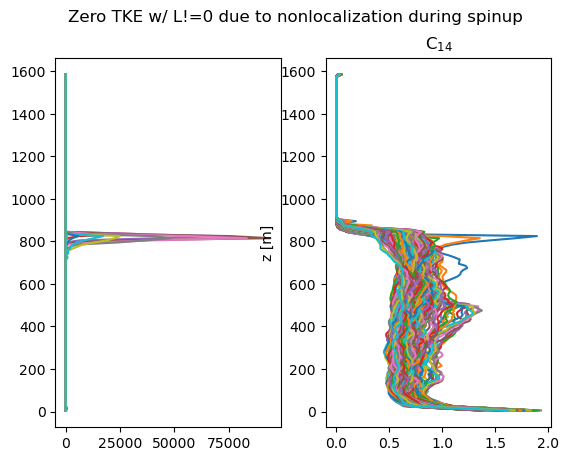

In [8]:
itime = range(30, ngrdcol)
kstart = 0
kend = nzm  # -21 #int(0.75*nzm)
fig, axs = plt.subplots ( 1, 2 )
axs[0].plot(C14[:, kstart:kend].T, zt[:, kstart:kend].T , label='All times')
axs[1].plot(C14[itime, kstart:kend].T, zt[itime, kstart:kend].T , label='t>30 h')
fig.suptitle("Zero TKE w/ L!=0 due to nonlocalization during spinup")
plt.ylabel("z [m]")
plt.title(r"C$_{14}$");

In [9]:
U2DFSN = sam.stagger_var("U2DFSN", ds, zt)
V2DFSN = sam.stagger_var("V2DFSN", ds, zt)

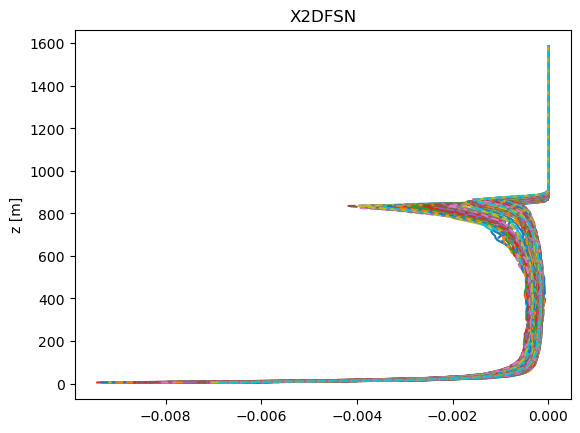

In [10]:
plt.plot(
    U2DFSN[itime, kstart:kend].T, zt[itime, kstart:kend].T, "-"
)  # ,label='U2DFSN')
plt.plot(
    V2DFSN[itime, kstart:kend].T, zt[itime, kstart:kend].T, "--"
)  # label='V2DFSN')
plt.ylabel("z [m]")
plt.title("X2DFSN");

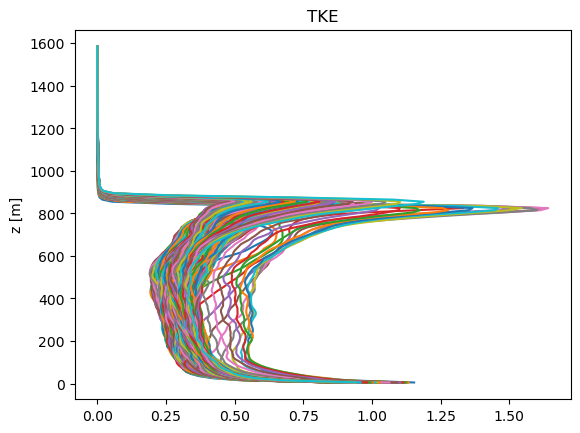

In [11]:
U2 = sam.stagger_var("U2", ds, zt)
V2 = sam.stagger_var("V2", ds, zt)
W2 = sam.stagger_var("W2", ds, zt)
e = 0.5 * (U2 + V2 + W2)

plt.plot(e[itime, kstart:kend].T, zt[itime, kstart:kend].T, label="e")
plt.ylabel("z [m]")
plt.title("TKE");

In [12]:
print(np.sum(C14 < 0))
print(np.sum(C14 == 0))
print(np.sum(C14 > 0))
print(np.sum(C14 > 10000))

196
9078
28886
23


In [13]:
print(np.sum((U2DFSN + V2DFSN) < 0))
print(np.sum((U2DFSN + V2DFSN) == 0))
print(np.sum((U2DFSN + V2DFSN) > 0))

28886
9078
196


In [14]:
np.sum((U2DFSN[itime, :-21] + V2DFSN[itime, :-21]) > 0)

np.int64(89)

In [15]:
print(np.sum(e < 0))
print(np.sum(e == 0))

0
0


In [16]:
L, Lup, Ldown = get_mixing_length(ds)
np.sum(L <= 0)

np.int64(0)

In [17]:
# kend = np.argmin(np.abs(zt[itime]-2000))
# plt.hist(C14[:,kstart:kend].flatten(),bins = 100);

In [18]:
C14_nonNeg = C14[C14 >= 0]
C14_pos = C14[C14 > 0]

Text(0, 0.5, 'Count')

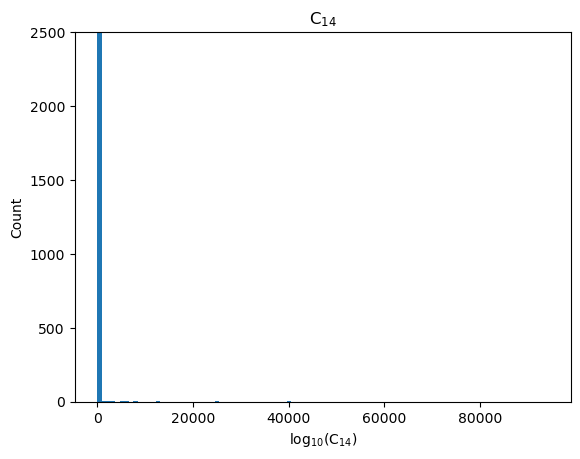

In [19]:
# plt.hist(np.log10(C14_nonNeg),bins = 100);
plt.hist(C14_nonNeg, bins=100)
plt.ylim((0, 2500))
plt.title(r"C$_{14}$")
plt.xlabel(r"log$_{10}$(C$_{14}$)")
plt.ylabel("Count")

In [20]:
print(np.mean(C14))
print(np.mean(C14_nonNeg))
print(np.mean(C14_pos))

25.263259870085367
25.401251012899817
33.38409933717817
